# 1. Setup Spark session

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("recommendation").getOrCreate()

In [4]:
# Show the Spark version:
print ("My Spark version is %s" % spark.version)
print ("The default parallelism factor, which indicates how many executors are running: %s"% spark.sparkContext.defaultParallelism)

My Spark version is 2.2.1
The default parallelism factor, which indicates how many executors are running: 4


# 2. Loading data in Spark

We will load the data from CSV files into Spark DataFrame

In [5]:
movies = spark.read.csv('data/movie_lens/movies.csv', inferSchema=True, header=True)

In [6]:
movies.cache()

DataFrame[movieId: int, title: string, genres: string]

In [8]:
ratings = spark.read.csv('data/movie_lens/ratings.csv', inferSchema=True, header=True)

In [9]:
ratings.cache()

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [10]:
print ('Number of records of movies: %d'% movies.count())
print ('Number of records of ratings: %d'% ratings.count())

Number of records of movies: 9125
Number of records of ratings: 100004


In [11]:
print ("Number of partitions for the movies DataFrame: " + str(movies.rdd.getNumPartitions()))
print ("Number of partitions for the ratings DataFrame: " + str(ratings.rdd.getNumPartitions()))

Number of partitions for the movies DataFrame: 1
Number of partitions for the ratings DataFrame: 1


# 3. Explore the data with Spark APIs¶

You'll use the Spark DataFrame API and SparkSQL to look at the data. Show the content of the DataFrame in a table:

In [12]:
movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [13]:
movies.show(truncate=False)

+-------+-------------------------------------+-------------------------------------------+
|movieId|title                                |genres                                     |
+-------+-------------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                     |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                       |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)              |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)             |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)   |Comedy                                     |
|6      |Heat (1995)                          |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                       |Comedy|Romance                             |
|8      |Tom and Huck (1995)                  |Adventure|Children               

In [14]:
ratings.show(truncate=False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |31     |2.5   |1260759144|
|1     |1029   |3.0   |1260759179|
|1     |1061   |3.0   |1260759182|
|1     |1129   |2.0   |1260759185|
|1     |1172   |4.0   |1260759205|
|1     |1263   |2.0   |1260759151|
|1     |1287   |2.0   |1260759187|
|1     |1293   |2.0   |1260759148|
|1     |1339   |3.5   |1260759125|
|1     |1343   |2.0   |1260759131|
|1     |1371   |2.5   |1260759135|
|1     |1405   |1.0   |1260759203|
|1     |1953   |4.0   |1260759191|
|1     |2105   |4.0   |1260759139|
|1     |2150   |3.0   |1260759194|
|1     |2193   |2.0   |1260759198|
|1     |2294   |2.0   |1260759108|
|1     |2455   |2.5   |1260759113|
|1     |2968   |1.0   |1260759200|
|1     |3671   |3.0   |1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [15]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [16]:
ratings.describe().show()

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|            100004|            100004|            100004|              100004|
|   mean| 347.0113095476181|12548.664363425463| 3.543608255669773|1.1296390869392424E9|
| stddev|195.16383797819535|26369.198968815268|1.0580641091070326|1.9168582602710962E8|
|    min|                 1|                 1|               0.5|           789652009|
|    max|               671|            163949|               5.0|          1476640644|
+-------+------------------+------------------+------------------+--------------------+



We can use specific methods from the DataFrame API to compute any statistic:

In [17]:
print ("Number of different users: " + str(ratings.select('userId').distinct().count()))
print ("Number of different movies: " + str(ratings.select('movieId').distinct().count()))

Number of different users: 671
Number of different movies: 9066


In [18]:
print ("Number of movies with at least one rating higher than 4: " + str(ratings.filter('rating > 4').select('movieId').distinct().count()))

Number of movies with at least one rating higher than 4: 4035


You can also leverage your SQL knowledge to query the data. Spark version 2.0 is ANSI SQL-92 compliant and can run the 99 [TPC-DS](http://www.tpc.org/tpcds/) queries.

Find the number of movies with ratings higher than 4 again, this time with SQL:

In [19]:
ratings.registerTempTable('ratings')

In [20]:
spark.sql("SELECT COUNT(DISTINCT(movieId)) AS movies_rated_4plus FROM ratings WHERE rating > 4").show()

+------------------+
|movies_rated_4plus|
+------------------+
|              4035|
+------------------+



# 4. Pandas data exploration

In [46]:
import pandas as pd
import numpy as np
from IPython.display import HTML

In [22]:
movies_pdf = pd.read_csv('data/movie_lens/movies.csv',
                         dtype={'movieId': np.int64, 'title':np.str,'genres':np.str}
                    )

In [23]:
rating_pdf = pd.read_csv('data/movie_lens//ratings.csv',
                         dtype={'userId': np.int64, 'movieId': np.int64, 'rating':np.double,'timestamp':np.long}
                    )

## What are the 10 most rated movies? 

In [44]:
# create one merged DataFrame
movie_ratings = pd.merge(movies_pdf, rating_pdf)

In [56]:
most_rated = movie_ratings.groupby('title').size().sort_values(ascending=False)[:10]

In [57]:
most_rated

title
Forrest Gump (1994)                          341
Pulp Fiction (1994)                          324
Shawshank Redemption, The (1994)             311
Silence of the Lambs, The (1991)             304
Star Wars: Episode IV - A New Hope (1977)    291
Jurassic Park (1993)                         274
Matrix, The (1999)                           259
Toy Story (1995)                             247
Schindler's List (1993)                      244
Terminator 2: Judgment Day (1991)            237
dtype: int64

In [59]:
# it can also be done using the value_counts function
movie_ratings.title.value_counts()[:10]

Forrest Gump (1994)                          341
Pulp Fiction (1994)                          324
Shawshank Redemption, The (1994)             311
Silence of the Lambs, The (1991)             304
Star Wars: Episode IV - A New Hope (1977)    291
Jurassic Park (1993)                         274
Matrix, The (1999)                           259
Toy Story (1995)                             247
Schindler's List (1993)                      244
Terminator 2: Judgment Day (1991)            237
Name: title, dtype: int64

In [24]:
import seaborn as sns
%matplotlib inline

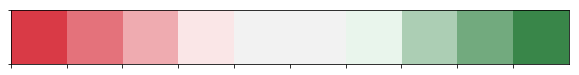

In [25]:
# The colour pallet we will use
sns.palplot(sns.diverging_palette(10, 133, sep=80, n=10))

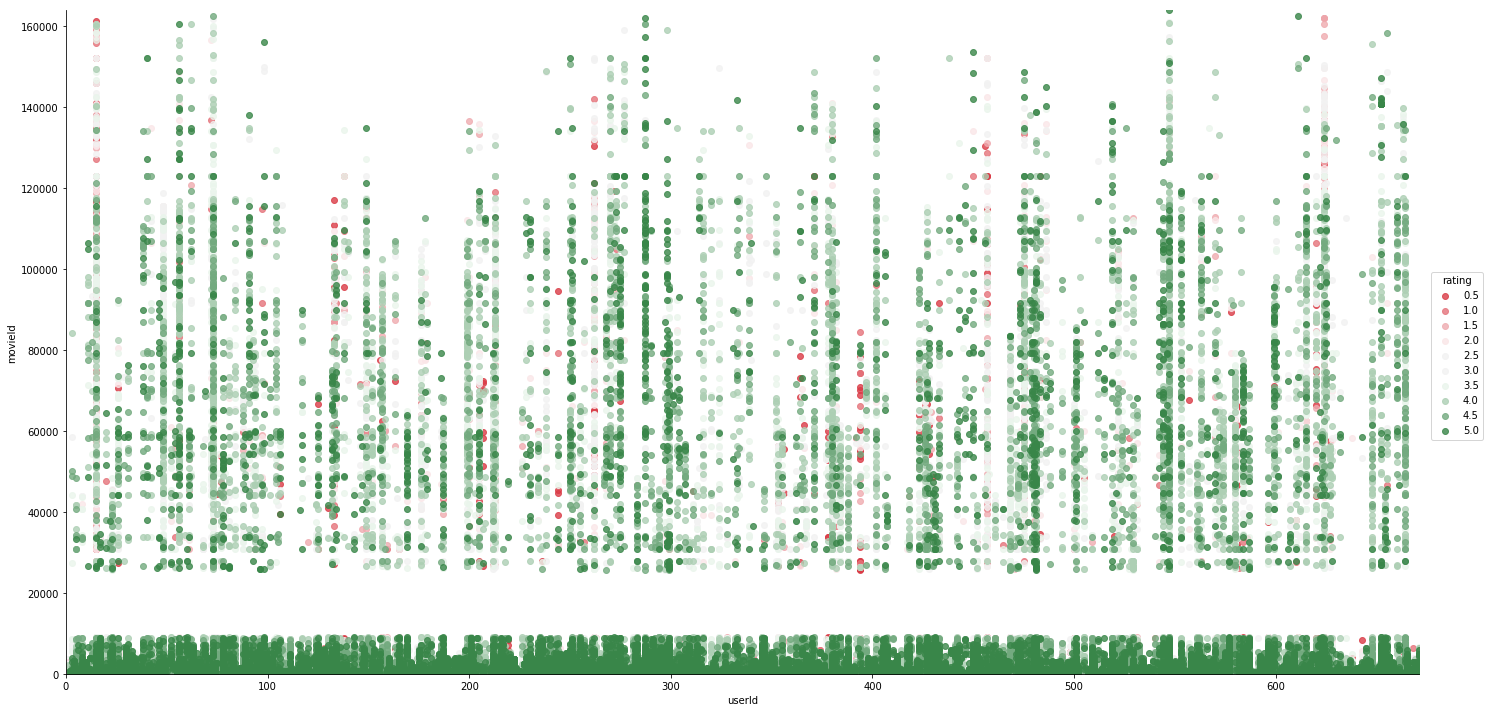

In [28]:
#Create the graph on a larger scale with the color palette:
lm = sns.lmplot(x='userId', y='movieId', hue='rating', 
                data=rating_pdf, fit_reg=False, size=10, aspect=2, 
                palette=sns.diverging_palette(10, 133, sep=80, n=10))
axes = lm.axes
axes[0,0].set_ylim(0,163949) # max movieId is 163949
axes[0,0].set_xlim(0,671) # max userId is 671
lm

On this matrix, you'll notice gaps in the data: some movies and users are missing. This is because you're using a subset of the data.

Nevertheless, you can identify some patterns. Some users always give positive reviews of movies. Some movies are rated a lot, which could be for different reasons, such as the first release of the MovieLens website had a much smaller catalog, or the movies are more famous.

Now visualize the global distribution of ratings with a violin plot:

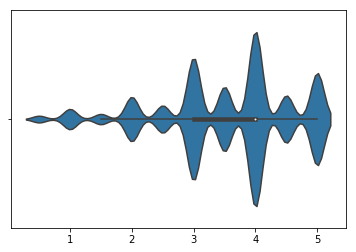

In [29]:
sns.violinplot([rating_pdf.rating],split=False,)

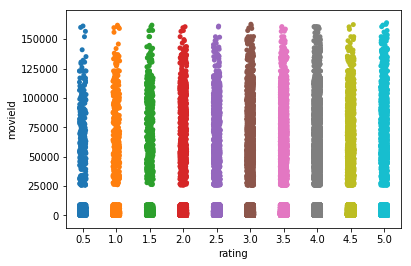

In [30]:
sns.stripplot(x="rating", y="movieId", data=rating_pdf, jitter=True)

More plat options can be found [here](https://seaborn.pydata.org/tutorial/categorical.html)

# 5. Build the recommender system

There are different methods for building a recommender system, such as, user-based, content-based, or collaborative filtering. Collaborative filtering calculates recommendations based on similarities between users and products. For example, collaborative filtering assumes that users who give the similar ratings on the same movies will also have similar opinions on movies that they haven't seen.

The alternating least squares (ALS) algorithm provides collaborative filtering between users and products to find products that the customers might like, based on their previous ratings.

In this case, the ALS algorithm will create a matrix of all users versus all movies. Most cells in the matrix will be empty. An empty cell means the user hasn't reviewed the movie yet. The ALS algorithm will fill in the probable ratings, based on similarities between user ratings and similarities between movies. The algorithm uses the least squares computation to minimize the estimation errors, and alternates between solving for movie factors and solving for user factors.

The following trivial example gives you an idea of the problem to solve. However, keep in mind that the general problem is much harder because the matrix often has far more missing values.

| User/Product | 1   | 2   | 3 | 4   | 5 |
|--------------|-----|-----|---|-----|---|
| 1            | 3.5 | 1   | 3 | 2   | ? |
| 2            | 1.5 | 4.5 | ? | 4   | 5 |
| 3            | 1   | ?   | ? | 4.5 | ? |
| 4            | 0.5 | 4   | 2 | 4   | ? |

Check the size of the ratings matrix:

In [63]:
spark.sql("""SELECT b.*, 100 * b.total_ratings/b.matrix_size AS percentage
                FROM (
                      SELECT a.unique_users, a.unique_movies, a.total_ratings, a.unique_users * a.unique_movies AS matrix_size 
                        FROM (
                              SELECT COUNT(*) AS total_ratings, COUNT(DISTINCT(movieId)) AS unique_movies, COUNT(DISTINCT(userId)) AS unique_users 
                                FROM ratings) a ) b""").show()

+------------+-------------+-------------+-----------+------------------+
|unique_users|unique_movies|total_ratings|matrix_size|        percentage|
+------------+-------------+-------------+-----------+------------------+
|         671|         9066|       100004|    6083286|1.6439141608663477|
+------------+-------------+-------------+-----------+------------------+



Looking at the table above we can see that less than 2% of the matrix is filled. This means we have a very sparse matrix

## 5.1 Train the model
Use the Spark ALS algorithm to train a model to provide recommendations. The mandatory parameters to the ALS algorithm are the columns that identify the users, the items, and the ratings. Run the fit() method to train the model:

In [64]:
from pyspark.ml.recommendation import ALS

model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating").fit(ratings)

## 5.2 Run the model
Run the transform() method to score the model and output a DataFrame with an additional prediction column that shows the predicted rating:

In [65]:
predictions = model.transform(ratings)
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   575|    148|   4.0|1012605106|  3.924297|
|   232|    463|   4.0| 955089443| 3.8561752|
|   452|    463|   2.0| 976424451| 2.4338357|
|   380|    463|   3.0| 968949106|  2.992769|
|   534|    463|   4.0| 973377486|   3.81207|
|   242|    463|   4.0| 956685706|  3.823004|
|    30|    463|   4.0| 945277405| 3.7022276|
|   311|    463|   3.0| 898008246| 2.9374855|
|    85|    471|   3.0| 837512312|  2.601095|
|   588|    471|   3.0| 842298526| 3.5137527|
|   126|    471|   5.0| 833287141| 3.9321887|
|   460|    471|   5.0|1072836030| 3.9795713|
|   350|    471|   3.0|1011714986| 3.4214778|
|   548|    471|   4.0| 857407799| 3.5484097|
|   602|    471|   3.0| 842357922| 4.0844736|
|   285|    471|   5.0| 965092130|  3.808179|
|   274|    471|   5.0|1074104142|  3.806779|
|   440|    471|   3.0| 835337519| 3.2848933|
|    86|    471|   4.0| 848161161|

You can see that many of the predictions are close to the actual ratings.

## 5.3 Evaluate the model
After you apply a model to a data set, you should evaluate the performance of the model by comparing the predicted values with the original values. Use the [RegressionEvaluator](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) method to compare continuous values with the root mean squared calculation. The root mean squared error calculation measures the average of the squares of the errors between what is estimated and the existing data. The lower the mean squared error value, the more accurate the model.

In [66]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions)))

The root mean squared error for our model is: 0.6091753885127366


You want the performance score to improve with your design iterations so that the model is improved. But notice that you just ran the training and the scoring on the same data set. That's something that you won't normally do because you usually want to predict values that you don't already know! Therefore, this result is nonsense. To accurately evaluate the model, it's common practice in machine learning to split the data set between a training data set to train the model, and a test data set to compare the predicted results with the original results. This process is called cross-validation. Not doing cross-validation often leads to overfitting, which occurs when the model is too specific to the training data set and does not perform well on a more general data set. Here's the general iterative process of machine learning:

## 5.4 Split the data set
Split your ratings data set between an 80% training data set and a 20% test data set. Then rerun the steps to train, run, and evaluate the model.

In [67]:
ratings_train, ratings_test = ratings.randomSplit([80.0, 20.0])

In [68]:
# initiate model object
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating")
# fit the model of train data
model = als.fit(ratings_train)
# test the model
predictions = model.transform(ratings_test)

In [69]:
predictions.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   242|    463|   4.0| 956685706| 3.6359515|
|   126|    471|   5.0| 833287141| 3.5969183|
|   548|    471|   4.0| 857407799| 3.2496085|
|   292|    471|   3.5|1140049920| 3.7379155|
|   491|    471|   3.0| 940797129|  4.869999|
|   659|    471|   4.0| 853412972|  3.678884|
|   380|    471|   4.0| 949367667| 3.2482553|
|   624|    471|   4.0|1178980875| 4.0248795|
|   195|    471|   3.0| 976289176| 3.3622684|
|   242|    471|   5.0| 956686752| 4.2352796|
|    30|    471|   4.0| 945112993| 3.5041986|
|   547|    496|   3.0| 974778561|  2.368116|
|   294|    833|   2.0|1047074195| 2.5198483|
|   262|   1088|   2.0|1433938031| 1.2488694|
|   358|   1088|   3.0| 957481379| 3.2732933|
|   505|   1088|   4.0|1340407488| 2.9421775|
|   518|   1088|   4.0| 945362333| 4.1831694|
|   621|   1088|   3.5|1116476035| 3.3835542|
|   213|   1088|   3.0|1462638479|

Evaluatming the model:
**You might get the value nan (not a number) due to issue called cold start**

In [70]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions)))

The root mean squared error for our model is: nan


## 5.5 Handling NaN issue using average

A NaN result is due to [SPARK-14489](https://issues.apache.org/jira/browse/SPARK-14489) and because the model can't predict values for users for which there's no data. A temporary workaround is to exclude rows with predicted NaN values or to replace them with a constant, for example, the general mean rating. However, to map to a real business problem, the data scientist, in collaboration with the business owner, must define what happens if such an event occurs. For example, you can provide no recommendation for a user until that user rates a few items. Alternatively, before user rates five items, you can use a user-based recommender system that's based on the user's profile (that's another recommender system to develop).

Replace predicted NaN values with the average rating and evaluate the model:

In [71]:
# get the average rating from entire dataset
avgRatings = ratings.select('rating').groupBy().avg().first()[0]
print ("The average rating in the dataset is: " + str(avgRatings))

# replace ``nan`` with average ratings 
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.fill(avgRatings))))

The average rating in the dataset is: 3.543608255669773
The root mean squared error for our model is: 0.925988067188896


## 5.6 Drop the na values

Now exclude predicted NaN values and evaluate the model:

In [72]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions.na.drop())))

The root mean squared error for our model is: 0.9145178790376494


You get similar performance as the previous model (using mean for missing ratings), but you're protected against overfitting: you will actually get this level of performance on new incoming data!

## 5.7 Using cold start Option to train the model in Spark >2.0

Use the solution mentioned [pull request](https://github.com/apache/spark/pull/12896). It is similar to 5.6, but now the model is handling missing values for us

In [73]:
# initiate model object
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")## present in Spark > 2
# fit the model of train data 
model = als.fit(ratings_train)
# test the model
predictions = model.transform(ratings_test)

In [74]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions)))

The root mean squared error for our model is: 0.9145178790376494


## 5.8 Improve the performance score

because the randomSplit() and ALS() functions have some randomness. To get a more precise performance score, run the model several times and then compute the average performance score. This process is really close to k-fold cross validation.

Create a repeatALS function that trains, runs, and evaluates the model multiple times:

In [76]:
def repeatALS(data, k=3, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    for i in range(0, k):  
        (trainingSet, testingSet) = data.randomSplit([k-1.0, 1.0])
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        model = als.fit(trainingSet)
        predictions = model.transform(testingSet)
        evaluator = RegressionEvaluator(metricName=metricName, labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        print ("Loop " + str(i+1) + ": " + metricName + " = " + str(evaluation))
        evaluations.append(evaluation)
    return sum(evaluations)/float(len(evaluations))

Run repeatALS four times and average the performance scores:

In [ ]:
print ("Average RMSE = " + str(repeatALS(ratingsdf, k=4)))

The computed performance score is more stable this way.

Create a ``kfoldALS`` function that also trains, runs, and evaluates the model, but splits up the data between training and testing data sets in a different way. The original data set is split into k data sets. Each of the k iterations of the function uses a different data set for testing and the other data sets for training.

In [ ]:
spark.sparkContext.emptyRDD

In [79]:
def kfoldALS(data, k=3, userCol="userId", itemCol="movieId", ratingCol="rating", metricName="rmse"):
    evaluations = []
    weights = [1.0] * k
    splits = data.randomSplit(weights)
    
    # always keep 1 part in test and remaining in train
    for i in range(0, k):  
        testingSet = splits[i]
        trainingSet = spark.createDataFrame(spark.sparkContext.emptyRDD(), data.schema)
        for j in range(0, k):
            if i == j:
                continue
            else:
                #trainingSet = trainingSet.unionAll(splits[j]) #  Saprk < 2.0
                trainingSet = trainingSet.union(splits[j])     # Spark > 2.0
        # create ALS        
        als = ALS(userCol=userCol, itemCol=itemCol, ratingCol=ratingCol)
        # fit the model
        model = als.fit(trainingSet)
        # get the predictions
        predictions = model.transform(testingSet)
        # evalue the model by RMSE from predictions - na values are dropped
        evaluator = RegressionEvaluator(metricName=metricName, labelCol="rating", predictionCol="prediction")
        evaluation = evaluator.evaluate(predictions.na.drop())
        
        print ("Loop " + str(i+1) + ": " + metricName + " = " + str(evaluation))
        evaluations.append(evaluation)
    return sum(evaluations)/float(len(evaluations))

In [81]:
print ("RMSE = " + str(kfoldALS(ratings, k=4)))

Loop 1: rmse = 0.9163010540142519
Loop 2: rmse = 0.9132039776959184
Loop 3: rmse = 0.9257124592638766
Loop 4: rmse = 0.920288811509904
RMSE = 0.9188765756209877


Now we compute the average performance score for 10 folds:

In [ ]:
print "RMSE = " + str(kfoldALS(ratings, k=10))


The bigger the training set is, the better performances you get. A general assumption in machine learning is that more data usually beats a better algorithm. You can easily improve this performance score by using the full data set

## 5.9 Improve the model - Use Grid search

So now, how can we improve this model? Machine learning algorithms have hyperparameters that control how the algorithm works.

The ALS algorithm has this signature
```java
class pyspark.ml.recommendation.ALS(
        rank=10,
        maxIter=10,
        regParam=0.1,
        numUserBlocks=10,
        numItemBlocks=10,
        implicitPrefs=false,
        alpha=1.0,
        userCol="user",
        itemCol="item",
        seed=None,
        ratingCol="rating",
        nonnegative=false,
        checkpointInterval=10,
        intermediateStorageLevel="MEMORY_AND_DISK",
        finalStorageLevel="MEMORY_AND_DISK"
    )
```

The ALS hyperparameters are:

> **rank** = the number of latent factors in the model

> **maxIter**= the maximum number of iterations

> **regParam** = the regularization parameter

To test several values for those hyperparameters and choose the best configuration, it's common practice to define a grid of parameter combinations and to run a grid search over the combinations to evaluate the resulting models and comparing their performance. This process is known as model selection.

The Spark [CrossValidator function](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation) performs a grid search as well as k-fold cross validation. Run the CrossValidator function with multiple values for rank and regParam:

In [82]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# split the data
(trainingRatings, validationRatings) = ratings.randomSplit([90.0, 10.0])
# define evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
#define the Grid of parameters
paramGrid = ParamGridBuilder().addGrid(als.rank, [1, 5, 10]).addGrid(als.maxIter, [20]).addGrid(als.regParam, [0.05, 0.1, 0.5]).build()
# define cross validator
crossval = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [83]:
# Fir the model using cross validation
cvModel = crossval.fit(trainingRatings)

In [84]:
# 
predictions = cvModel.transform(validationRatings)

print ("The root mean squared error for our model is: " + str(evaluator.evaluate(predictions)))#.na.drop()

The root mean squared error for our model is: 0.9070910504880428


The more folds and parameters you add to the grid, the longer it takes to test any combination. The CrossValidator model contains more information about the performance for each combination that you can get with the avgMetrics() method. For example, you can graph the results on a plot for analysis.

Unfortunately, because of the [SPARK-14489](https://issues.apache.org/jira/browse/SPARK-14489) issue mentioned above, the CrossValidator function can't compute the root mean squared error most of the time and provides incorrect results. You could limit this problem by making the training set much larger than the test set, but that's not a good practice. If you want to learn more about this issue, which is more a conceptual one than a technical one, and how this is being solved in the next Spark 2.2 release, you can have a look at Nick Pentreath's pull request [#12896](https://github.com/apache/spark/pull/12896). Welcome to the Open Source world!

In [85]:
best_model=cvModel.bestModel

In [86]:
Top10_Movies = best_model.recommendForAllUsers(10).take(10)

# 6. Check recommendations for the first user

In [87]:
list(row['movieId'] for row in Top10_Movies[0][1] )

[3414, 59684, 31435, 65037, 54328, 83411, 83318, 83359, 106471, 1860]

In [88]:
movies.registerTempTable('movies')

In [89]:
# Get recommended movies for user Id 471
recommedations = [4076,4591,1563,4796,4930,1450,5427,107559,3216,92494] 

In [90]:
spark.sql('SELECT title, genres FROM movies WHERE movieId IN (4076,4591,1563,4796,4930,1450,5427,107559,3216,92494)').show(truncate=False)

+----------------------------------------------------------------+------------------------+
|title                                                           |genres                  |
+----------------------------------------------------------------+------------------------+
|Prisoner of the Mountains (Kavkazsky plennik) (1996)            |War                     |
|Dream With the Fishes (1997)                                    |Drama                   |
|Vampyros Lesbos (Vampiras, Las) (1971)                          |Fantasy|Horror|Thriller |
|Two Ninas (1999)                                                |Comedy|Romance          |
|Erik the Viking (1989)                                          |Adventure|Comedy|Fantasy|
|Grass Is Greener, The (1960)                                    |Comedy|Romance          |
|Funeral in Berlin (1966)                                        |Action|Drama|Thriller   |
|Caveman (1981)                                                  |Comedy        

## Adopted from

Some content was taken from [this](https://datascience.ibm.com/exchange/public/entry/view/99b857815e69353c04d95daefb3b91fa) article

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))